In [1]:
# default_exp data.tsloader_fast

In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
#export
import numpy as np
import pandas as pd
import random
import torch as t
import copy
from fastcore.foundation import patch
from nixtla.data.tsdataset import TimeSeriesDataset
from collections import defaultdict

In [4]:
# from torch.utils.data import Dataset

# class TimeSeriesDataset(Dataset):
#     def __init__(self,
#                  Y_df: pd.DataFrame,
#                  X_df: pd.DataFrame=None,
#                  S_df: pd.DataFrame=None,
#                  mask_df: pd.DataFrame=None,
#                  f_cols: list=None):
#         """
#         """
#         assert type(Y_df) == pd.core.frame.DataFrame
#         assert all([(col in Y_df) for col in ['unique_id', 'ds', 'y']])
#         if X_df is not None:
#             assert type(X_df) == pd.core.frame.DataFrame
#             assert all([(col in X_df) for col in ['unique_id', 'ds']])
#             assert len(Y_df)==len(X_df), f'The dimensions of Y_df and X_df are not the same'
#         assert len(Y_df)==len(mask_df), f'The dimensions of Y_df and mask_df are not the same'

#         print("Train Validation splits")
#         mask_df['train_mask'] = mask_df['available_mask'] * mask_df['sample_mask']
#         self.n_tstamps = len(mask_df)
#         self.n_avl = mask_df.available_mask.sum()        
#         self.n_trn = mask_df.train_mask.sum()
#         self.n_prd = len(mask_df)-mask_df.sample_mask.sum()

#         avl_prc = np.round(self.n_avl/self.n_tstamps,5)
#         trn_prc = np.round(self.n_trn/self.n_tstamps,5)
#         prd_prc = np.round(self.n_prd/self.n_tstamps,5)
#         print(mask_df.groupby(['unique_id', 'sample_mask']).agg({'ds': ['min', 'max']}))
#         print(f'Total data \t\t\t{self.n_tstamps} time stamps')
#         print(f'Available prc = {avl_prc}, \t{self.n_avl} time stamps')
#         print(f'Train prc = {trn_prc}, \t\t{self.n_trn} time stamps')
#         print(f'Predict prc = {prd_prc}, \t\t{self.n_prd} time stamps')
#         print('\n')

#         #print('\n')
#         #print('Processing dataframes ...')
#         #Pandas dataframes to data lists
#         if mask_df is None:
#             mask_df = Y_df[['unique_id', 'ds']].copy()
#             mask_df['available_mask'] = np.ones(len(Y_df))
#             mask_df['sample_mask'] = np.ones(len(Y_df))

#         ts_data, s_data, self.meta_data, self.t_cols, self.X_cols \
#                          = self._df_to_lists(Y_df=Y_df, S_df=S_df, X_df=X_df, mask_df=mask_df)

#         # Dataset attributes
#         self.n_series   = len(ts_data)
#         self.max_len    = max([len(ts['y']) for ts in ts_data])
#         self.n_channels = len(self.t_cols) # y, X_cols, insample_mask and outsample_mask
#         self.frequency  = pd.infer_freq(Y_df.head()['ds']) #TODO: improve, can die with head
#         self.f_cols     = f_cols

#         # Number of X and S features
#         self.n_x = 0 if X_df is None else len(self.X_cols)
#         self.n_s = 0 if S_df is None else S_df.shape[1]-1 # -1 for unique_id

#         # print('Creating ts tensor ...')
#         # Balances panel and creates 
#         # numpy  s_matrix of shape (n_series, n_s)
#         # numpy ts_tensor of shape (n_series, n_channels, max_len) n_channels = y + X_cols + masks
#         self.ts_tensor, self.s_matrix, self.len_series = self._create_tensor(ts_data, s_data)

#     def _df_to_lists(self, Y_df, S_df, X_df, mask_df):
#         """
#         """
#         unique_ids = Y_df['unique_id'].unique()

#         if X_df is not None:
#             X_cols = [col for col in X_df.columns if col not in ['unique_id','ds']]
#         else:
#             X_cols = []

#         if S_df is not None:
#             S_cols = [col for col in S_df.columns if col not in ['unique_id']]
#         else:
#             S_cols = []

#         ts_data = []
#         s_data = []
#         meta_data = []
#         for i, u_id in enumerate(unique_ids):
#             top_row    = np.asscalar(Y_df['unique_id'].searchsorted(u_id, 'left'))
#             bottom_row = np.asscalar(Y_df['unique_id'].searchsorted(u_id, 'right'))
            
#             # Y values
#             y_true = Y_df[top_row:bottom_row]['y'].values
#             ts_data_i = {'y': y_true}
            
#             # X values
#             for X_col in X_cols:
#                 serie =  X_df[top_row:bottom_row][X_col].values
#                 ts_data_i[X_col] = serie

#             # Mask values
#             available_mask = mask_df[top_row:bottom_row]['available_mask'].values
#             sample_mask = mask_df[top_row:bottom_row]['sample_mask'].values            
#             ts_data_i['available_mask'] = available_mask
#             ts_data_i['sample_mask']  = sample_mask
#             ts_data.append(ts_data_i)

#             # S values
#             s_data_i = defaultdict(list)
#             for S_col in S_cols:
#                 s_data_i[S_col] = S_df.loc[S_df['unique_id']==u_id, S_col].values
#             s_data.append(s_data_i)

#             # Metadata
#             last_ds_i  = Y_df[top_row:bottom_row]['ds'].max()
#             meta_data_i = {'unique_id': u_id,
#                            'last_ds': last_ds_i}
#             meta_data.append(meta_data_i)

#         #for tss in ts_data:
#         #    print("tss['y'].shape", tss['y'].shape)
#         #    for X_col in X_cols:
#         #        print("tss[X_col].shape", tss[X_col].shape)

#         t_cols = ['y'] + X_cols + ['available_mask', 'sample_mask']

#         return ts_data, s_data, meta_data, t_cols, X_cols

#     def _create_tensor(self, ts_data, s_data):
#         """
#         s_matrix of shape (n_series, n_s)
#         ts_tensor of shape (n_series, n_channels, max_len) n_channels = y + X_cols + masks
#         """
#         s_matrix  = np.zeros((self.n_series, self.n_s))
#         ts_tensor = np.zeros((self.n_series, self.n_channels, self.max_len))

#         print("ts_tensor.shape", ts_tensor.shape)

#         len_series = []
#         for idx in range(self.n_series):
#             # Left padded time series tensor
#             # TODO: Maybe we can place according to ds
#             ts_idx = np.array(list(ts_data[idx].values()))

#             print("ts_idx.shape", ts_idx.shape)

#             # ANTES
#             #ts_tensor[idx, :self.t_cols.index('outsample_mask'), -ts_idx.shape[1]:] = ts_idx
#             #ts_tensor[idx,  self.t_cols.index('insample_mask'), -ts_idx.shape[1]:] = 1
            
#             # To avoid sampling windows without inputs available to predict we shift -1
#             # outsample_mask will be completed with the train_mask, this ensures available data
#             #ts_tensor[idx,  self.t_cols.index('outsample_mask'), -(ts_idx.shape[1]-1):] = 1

#             # AHORA
#             ts_tensor[idx, :, -ts_idx.shape[1]:] = ts_idx
#             s_matrix[idx, :] = list(s_data[idx].values())
#             len_series.append(ts_idx.shape[1])

#             # ###########
#             # ###########
#             # ###########
#             # print("\n")
#             # markets = ['BE', 'FR', 'NP', 'PJM']
#             # available_mask = ts_tensor[idx, self.t_cols.index('available_mask'), :]
#             # sample_mask = ts_tensor[idx, self.t_cols.index('sample_mask'), :]
#             # train_mask = available_mask * sample_mask
#             # n_hours = len(available_mask)

#             # market = markets[idx]
#             # print(f'DATASET {market} Available Mask {np.round(np.sum(available_mask/n_hours),5)}')
#             # print(f'DATASET {market} Sample Mask {np.round(np.sum(sample_mask/n_hours),5)}')
#             # print(f'DATASET {market} Train Mask {np.round(np.sum(train_mask/n_hours),5)}')
#             # ###########
#             # ###########
#             # ###########

#         return ts_tensor, s_matrix, np.array(len_series)

#     def get_meta_data_col(self, col):
#         """
#         """
#         col_values = [x[col] for x in self.meta_data]
#         return col_values

#     def get_filtered_ts_tensor(self, offset, output_size, window_sampling_limit, ts_idxs=None):
#         """
#         Esto te da todo lo que tenga el tensor, el futuro incluido esto orque se usa exogenoas del futuro
#         La mascara se hace despues
#         """
#         last_outsample_ds = self.max_len - offset + output_size
#         first_ds = max(last_outsample_ds - window_sampling_limit - output_size, 0)
#         if ts_idxs is None:
#             filtered_ts_tensor = self.ts_tensor[:, :, first_ds:last_outsample_ds]
#         else:
#             filtered_ts_tensor = self.ts_tensor[ts_idxs, :, first_ds:last_outsample_ds]
#         right_padding = max(last_outsample_ds - self.max_len, 0) #To padd with zeros if there is "nothing" to the right

#         #assert np.sum(np.isnan(filtered_ts_tensor))<1.0, \
#         #    f'The balanced balanced filtered_tensor has {np.sum(np.isnan(filtered_ts_tensor))} nan values'
#         return filtered_ts_tensor, right_padding #ANTES, ts_train_mask

#     def get_f_idxs(self, cols):
#         # Check if cols are available f_cols and return the idxs
#         assert all(col in self.f_cols for col in cols), f'Some variables in {cols} are not available in f_cols.'
#         f_idxs = [self.X_cols.index(col) for col in cols]
#         return f_idxs
    

In [5]:
#export
# TODO: pensar variable shuffle para compatibilidad con dataloader de pytorch y keras
#.      por el momento tenemos solo validacion boostrapeada, no existe modo no shuffle
#.      para evaluacion no estocástica, nuestra validación está hackeada.
class TimeSeriesLoader(object):
    def __init__(self,
                 ts_dataset:TimeSeriesDataset,
                 model:str,
                 offset:int,
                 window_sampling_limit: int, 
                 input_size: int,
                 output_size: int,
                 idx_to_sample_freq: int, # TODO: Usada en hack ENORME para window frequency sampling
                 batch_size: int,
                 is_train_loader: bool,
                 shuffle:bool,
                 random_seed: int):
        """
        """
        # Dataloader attributes
        self.model = model
        self.window_sampling_limit = window_sampling_limit
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.idx_to_sample_freq = idx_to_sample_freq
        self.offset = offset
        self.ts_dataset = ts_dataset
        self.t_cols = self.ts_dataset.t_cols
        self.is_train_loader = is_train_loader # Boolean variable for train and validation mask
        self.shuffle = shuffle # Boolean to shuffle data, useful for validation
        self.random_seed = random_seed
        np.random.seed(self.random_seed)        

        assert offset==0, 'sample_mask and offset interaction not implemented'
        assert window_sampling_limit==self.ts_dataset.max_len, \
            'sample_mask and window_samplig_limit interaction not implemented'
        
        # Create rolling window matrix in advanced for faster access to data and broadcasted s_matrix
        self._create_sample_data()

    def _update_sampling_windows_idxs(self):
        # Only sample during available windows with at least one active output mask and input mask
        #n_windows, n_channels, max_len
        available_condition = t.sum(self.ts_windows[:, self.t_cols.index('available_mask'), :self.input_size], axis=1)
        sample_condition = t.sum(self.ts_windows[:, self.t_cols.index('sample_mask'), -self.output_size:], axis=1)
        
        #sampling_idx = t.nonzero(available_condition * sample_condition > 0)
        sampling_idx = t.nonzero(sample_condition)

        sampling_idx = list(sampling_idx.flatten().numpy())
        assert len(sampling_idx)>0, 'Check the data and masks as sample_idxs are empty'
        return sampling_idx

    def _create_windows_tensor(self):
        """
        Comment here
        TODO: Cuando creemos el otro dataloader, si es compatible lo hacemos funcion transform en utils
        """
        # Memory efficiency is gained from keeping across dataloaders common ts_tensor in dataset
        # Filter function is used to define train tensor and validation tensor with the offset
        # Default ts_idxs=ts_idxs sends all the data
        tensor, right_padding = self.ts_dataset.get_filtered_ts_tensor(offset=self.offset, output_size=self.output_size,
                                                                       window_sampling_limit=self.window_sampling_limit)
        tensor = t.Tensor(tensor)

        # Outsample mask checks existance of values in ts, train_mask mask is used to filter out validation
        # is_train_loader inverts the train_mask in case the dataloader is in validation mode
        # ###########
        # ###########
        # ###########
        # markets = ['BE', 'FR', 'NP', 'PJM']
        # for idx, market in enumerate(markets):
        #     print("\n")
        #     available_mask = tensor[idx, self.ts_dataset.t_cols.index('available_mask'), :]
        #     sample_mask = tensor[idx, self.ts_dataset.t_cols.index('sample_mask'), :]
        #     train_mask = available_mask * sample_mask
        #     n_hours = len(available_mask)
        #     print("available_mask.shape", available_mask.shape)

        #     print(f'LOADER {market} Available Mask {t.sum(available_mask/n_hours)}')
        #     print(f'LOADER {market} Sample Mask {t.sum(sample_mask/n_hours)}')
        #     print(f'LOADER {market} Train Mask {t.sum(train_mask/n_hours)}')
        #     ###########
        #     ###########
        #     ###########

        if self.is_train_loader:
            tensor[:, self.t_cols.index('sample_mask'), :] = \
                (tensor[:, self.t_cols.index('available_mask'), :] * tensor[:, self.t_cols.index('sample_mask'), :])
        else:
            tensor[:, self.t_cols.index('sample_mask'), :] = (1-tensor[:, self.t_cols.index('sample_mask'), :])

        padder = t.nn.ConstantPad1d(padding=(self.input_size, right_padding), value=0)
        tensor = padder(tensor)

        # Creating rolling windows and 'flattens' them
        windows = tensor.unfold(dimension=-1, size=self.input_size + self.output_size, step=self.idx_to_sample_freq)
        # n_serie, n_channel, n_time, window_size -> n_serie, n_time, n_channel, window_size
        #print(f'n_serie, n_channel, n_time, window_size = {windows.shape}')
        windows = windows.permute(0,2,1,3)
        #print(f'n_serie, n_time, n_channel, window_size = {windows.shape}')
        windows = windows.reshape(-1, self.ts_dataset.n_channels, self.input_size + self.output_size)

        # Broadcast s_matrix: This works because unfold in windows_tensor, orders: time, serie
        s_matrix = self.ts_dataset.s_matrix.repeat(repeats=int(len(windows)/self.ts_dataset.n_series), axis=0)

        return windows, s_matrix, tensor

    def __len__(self):
        return len(self.len_series)

    def __iter__(self):
        if self.shuffle:
            sample_idxs = np.random.choice(a=self.windows_sampling_idx,
                                           size=len(self.windows_sampling_idx), replace=False)
        else:
            sample_idxs = self.windows_sampling_idx

        n_batches = int(np.ceil(len(sample_idxs) / self.batch_size)) # Must be multiple of batch_size for paralel gpu
        
        for idx in range(n_batches):
            ws_idxs = sample_idxs[(idx * self.batch_size) : (idx + 1) * self.batch_size]
            batch = self.__get_item__(index=ws_idxs)
            yield batch

    def __get_item__(self, index):
        if self.model == 'nbeats':
            return self._windows_batch(index)
        elif self.model == 'esrnn':
            #return self._full_series_batch(index)
            assert 1<0, 'Hierarchical sampling not implemented'
        else:
            assert 1<0, 'error'

    def _windows_batch(self, index):
        """ NBEATS, TCN models """

        # Access precomputed rolling window matrix (RAM intensive)
        windows = self.ts_windows[index]
        s_matrix = self.s_matrix[index]

        insample_y = windows[:, self.t_cols.index('y'), :self.input_size]
        insample_x = windows[:, (self.t_cols.index('y')+1):self.t_cols.index('available_mask'), :self.input_size]
        available_mask = windows[:, self.t_cols.index('available_mask'), :self.input_size]

        outsample_y = windows[:, self.t_cols.index('y'), self.input_size:]
        outsample_x = windows[:, (self.t_cols.index('y')+1):self.t_cols.index('available_mask'), self.input_size:]
        sample_mask = windows[:, self.t_cols.index('sample_mask'), self.input_size:]

        batch = {'s_matrix': s_matrix,
                 'insample_y': insample_y, 'insample_x':insample_x, 'insample_mask':available_mask,
                 'outsample_y': outsample_y, 'outsample_x':outsample_x, 'outsample_mask':sample_mask}
        return batch

    # def _full_series_batch(self, index):
    #     """ ESRNN, RNN models """
        
    #     print("[index]", index)
    #     print("self.ts_tensor.shape", self.ts_tensor.shape)

    #     ts_tensor = self.ts_tensor[index]

    #     # Trim batch to shorter time series to avoid zero padding
    #     insample_y = ts_tensor[:, self.t_cols.index('y'), :]
    #     batch_len_series = np.array(self.ts_dataset.len_series)[index]
    #     min_batch_len = np.min(batch_len_series)
    #     insample_y = insample_y[:, -min_batch_len:]

    #     insample_x = ts_tensor[:, self.t_cols.index('y')+1:self.t_cols.index('insample_mask'), :]
    #     insample_x = insample_x[:, -min_batch_len:]

    #     s_matrix = self.ts_dataset.s_matrix[index]

    #     batch = {'insample_y': insample_y, 'idxs': index, 'insample_x': insample_x, 's_matrix': s_matrix}

    #     return batch

    def _create_sample_data(self):
        """
        """
        # print('Creating windows matrix ...')
        # Create rolling window matrix for fast information retrieval
        self.ts_windows, self.s_matrix, _ = self._create_windows_tensor()
        self.n_windows = len(self.ts_windows)
        self.windows_sampling_idx = self._update_sampling_windows_idxs()

        #expected_windows = self.ts_dataset.n_trn if self.is_train_loader else self.ts_dataset.n_prd
        #assert expected_windows == (len(self.windows_sampling_idx) * self.idx_to_sample_freq), \
        #    f'Check predict windows {self.ts_dataset.n_trn} sample windows {len(self.windows_sampling_idx)}'
        assert (self.ts_dataset.n_prd % self.ts_dataset.n_series == 0), 'Predictions tensor is unbalanced'
        assert (self.ts_dataset.n_prd % self.idx_to_sample_freq == 0), 'Predictions tensor is unbalanced'

    def update_offset(self, offset):
        if offset == self.offset:
            return # Avoid extra computation
        self.offset = offset
        self._create_train_data()

    def get_meta_data_col(self, col):
        return self.ts_dataset.get_meta_data_col(col)

    def get_n_variables(self):
        return self.ts_dataset.n_x, self.ts_dataset.n_s

    def get_n_series(self):
        return self.ts_dataset.n_series

    def get_max_len(self):
        return self.ts_dataset.max_len

    def get_n_channels(self):
        return self.ts_dataset.n_channels

    def get_X_cols(self):
        return self.ts_dataset.X_cols

    def get_frequency(self):
        return self.ts_dataset.frequency

# TESTING DATALOADERS



Y_df.shape 			 (34944, 3)
Xt_df.shape 			 (34944, 12)
Y_balanced_df.shape 		 (34944, 3)
Xt_balanced_df.shape 		 (34944, 12)
weights_balanced_df.shape 	 (34944, 3)


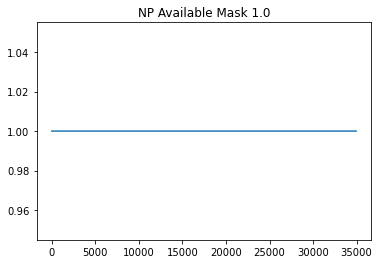

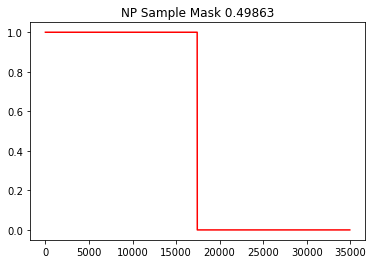

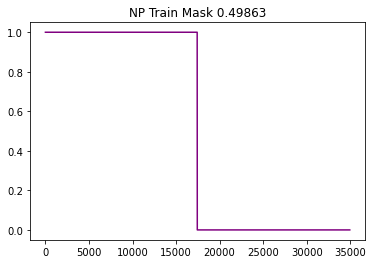

In [6]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from nixtla.data.datasets.epf import EPF, EPFInfo
from nixtla.data.scalers import Scaler

# Hacked MAE NP hypars
hacked_np = {'input_size_multiplier': 7,
             'output_size': 24,
             'window_sampling_limit': 365*10*24,
             'idx_to_sample_freq': 24,
             'batch_size': 256,
             'shared_weights': False,
             'activation': 'relu',
             'initialization': 'he_normal',
             'stack_types': ['exogenous_tcn']+1*['identity'],
             'n_blocks': 2*[1],
             'n_layers': 2*[2],
             'n_hidden': 2*[[462,462]],
             'n_polynomials': 2,
             'n_harmonics': 1,
             'exogenous_n_channels': 8,
             'include_var_dict': {'y': [-2, -3, -8],
                                  'Exogenous1': [-1, -2, -8],
                                  'Exogenous2': [-1, -2, -8],
                                  'week_day': [-1]},
             'batch_normalization': False,
             'dropout_prob_theta': 0.05,
             'dropout_prob_exogenous': 0.35,
             'x_s_n_hidden': 0,
             'learning_rate': 0.0016,
             'lr_decay': 0.5,
             'n_lr_decay_steps': 3,
             'weight_decay': 6e-4,
             'l1_theta': 1.0e-05,
             'n_iterations': 50, #2000 <-------------
             'early_stopping': 40,
             'loss': 'PINBALL',
             'loss_hypar': 0.49,
             'val_loss': 'MAE', #'SMAPE',
             'frequency': 'H',
             'random_seed': 17,
             'seasonality': 24}

def get_last_n_timestamps_mask_df(Y_df, n_timestamps):
    # Creates outsample_mask
    # train 1 validation 0

    last_df = Y_df.copy()[['unique_id', 'ds']]
    last_df.sort_values(by=['unique_id', 'ds'], inplace=True, ascending=False)
    last_df.reset_index(drop=True, inplace=True)

    last_df = last_df.groupby('unique_id').head(n_timestamps)
    last_df['mask'] = 1

    last_df = last_df[['unique_id', 'ds', 'mask']]

    mask_df = Y_df.merge(last_df, on=['unique_id', 'ds'], how='left')
    mask_df['mask'] = mask_df['mask'].fillna(0)    # The first len(Y)-n_hours used as train

    mask_df = mask_df[['unique_id', 'ds', 'mask']]
    mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)

    assert len(mask_df)==len(Y_df), \
        f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'

    return mask_df

def scale_data(Xt_df, mask_df):
    # TODO: write sample_mask conditional/groupby(['unique_id]) scaling
    # Conditional on sample_mask, scale all the Exogenous variables.

    # To not modify original data
    Xt_scaled_df = Xt_df.copy()

    # Transform data with scale transformation
    scaler = Scaler(normalizer='norm')
    Xt_scaled_df['Exogenous1'] = scaler.scale(x=Xt_scaled_df['Exogenous1'].values, 
                                              mask=mask_df.sample_mask.values)

    scaler = Scaler(normalizer='norm')
    Xt_scaled_df['Exogenous2'] = scaler.scale(x=Xt_scaled_df['Exogenous2'].values,
                                              mask=mask_df.sample_mask.values)

    return Xt_scaled_df

def balance_data(Y_df, Xt_df):
    # Train Validation splits
    #                        ds                    
    #                       min                 max
    # unique_id mask                               
    # BE        0.0  2013-01-04 2015-01-03 23:00:00
    #           1.0  2011-01-09 2013-01-03 23:00:00
    # FR        0.0  2013-01-04 2015-01-03 23:00:00
    #           1.0  2011-01-09 2013-01-03 23:00:00
    # NP        0.0  2014-12-28 2016-12-26 23:00:00
    #           1.0  2013-01-01 2014-12-27 23:00:00
    # PJM       0.0  2014-12-28 2016-12-26 23:00:00
    #           1.0  2013-01-01 2014-12-27 23:00:00

    # Create balanced placeholder dataframe
    balance_ids = {'unique_id': Y_df.unique_id.unique(),
                   'ds': Y_df.ds.unique()}

    product_list = list(itertools.product(*list(balance_ids.values())))
    balance_df = pd.DataFrame(product_list, columns=list(balance_ids.keys()))

    # Create mask for weighted losses for the las 2 years of each unique_id
    weights_df = get_last_n_timestamps_mask_df(Y_df=Y_df, n_timestamps=2*365*24)
    weights_df['weights'] = weights_df['mask']
    del weights_df['mask']
    
    # Balance with merge
    Y_balanced_df = balance_df.merge(Y_df, on=['unique_id', 'ds'], how='left')
    Xt_balanced_df = balance_df.merge(Xt_df, on=['unique_id', 'ds'], how='left')
    weights_balanced_df = balance_df.merge(weights_df, on=['unique_id', 'ds'], how='left')
    #print(weights_balanced_df.groupby(['unique_id', 'weights']).agg({'ds': ['min', 'max']}))

    print('\n')
    print('Y_df.shape \t\t\t', Y_df.shape)
    print('Xt_df.shape \t\t\t', Xt_df.shape)
    print('Y_balanced_df.shape \t\t', Y_balanced_df.shape)
    print('Xt_balanced_df.shape \t\t', Xt_balanced_df.shape)
    print('weights_balanced_df.shape \t', weights_balanced_df.shape)

    return Y_balanced_df, Xt_balanced_df, weights_balanced_df

# args = pd.Series({'dataset': ['NP', 'PJM', 'BE', 'FR']})
args = pd.Series({'dataset': ['NP']})

Y_df, Xt_df, S_df = EPF.load_groups(directory='data', groups=args.dataset)
Y_balanced_df, Xt_balanced_df, weights_balanced_df = balance_data(Y_df, Xt_df)
del Y_df, Xt_df

# Train Validation splits
#                           ds                    
#                          min                 max
# unique_id weights                               
# BE        0.0     2011-01-09 2013-01-03 23:00:00
#           1.0     2013-01-04 2015-01-03 23:00:00
# FR        0.0     2011-01-09 2013-01-03 23:00:00
#           1.0     2013-01-04 2015-01-03 23:00:00
# NP        0.0     2013-01-01 2014-12-27 23:00:00
#           1.0     2014-12-28 2016-12-26 23:00:00
# PJM       0.0     2013-01-01 2014-12-27 23:00:00
#           1.0     2014-12-28 2016-12-26 23:00:00

# Create available_mask and sample_mask
# TODO: Include not null exogenous condition to available mask
mask_df = Y_balanced_df[['unique_id', 'ds', 'y']].copy()
mask_df['available_mask'] = (1-Y_balanced_df.y.isnull().values)
del mask_df['y']

mask_df['sample_mask1'] = (mask_df['ds'] <= pd.to_datetime('2013-01-03 23:00:00')) * 1
mask_df['sample_mask2'] = (mask_df['ds'] <= pd.to_datetime('2014-12-27 23:00:00')) * 1
mask_df['sample_mask'] = mask_df['sample_mask2']

# Scale data # TODO: write sample_mask conditional/groupby(['unique_id]) scaling
Xt_scaled_df = scale_data(Xt_df=Xt_balanced_df, mask_df=mask_df)
del Xt_balanced_df

# mask_df.groupby(['unique_id', 'available_mask', 'sample_mask']).agg({})
market = 'NP'
available_mask = mask_df[mask_df.unique_id==market].available_mask.values
sample_mask = mask_df[mask_df.unique_id==market].sample_mask.values
train_mask = available_mask * sample_mask
n_hours = len(available_mask)

plt.plot(range(n_hours), available_mask)
plt.title(f'{market} Available Mask {np.round(np.sum(available_mask/n_hours),5)}')
plt.show()

plt.plot(range(n_hours), sample_mask, color='red')
plt.title(f'{market} Sample Mask {np.round(np.sum(sample_mask/n_hours),5)}')
plt.show()

plt.plot(range(n_hours), train_mask, color='purple')
plt.title(f'{market} Train Mask {np.round(np.sum(train_mask/n_hours),5)}')
plt.show()

# TESTING SAMPLING_MASK ON DATALOADERS

In [7]:
mc = hacked_np

train_mask_df = mask_df.copy()
train_mask_df['sample_mask'] = (mask_df['available_mask'].values) * (1-mask_df['sample_mask'].values)
print("train percentage", sum(train_mask_df['sample_mask'])/len(train_mask_df['sample_mask']))

ts_dataset = TimeSeriesDataset(Y_df=Y_balanced_df, X_df=Xt_scaled_df, S_df=S_df, mask_df=mask_df)

train_loader = TimeSeriesLoader(ts_dataset=ts_dataset,
                                model='nbeats',
                                offset=0, #offset,
                                window_sampling_limit=ts_dataset.max_len, 
                                input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                output_size=int(mc['output_size']),
                                idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                                batch_size=int(mc['batch_size']),
                                is_train_loader=True,
                                shuffle=True)

print("train_loader.ts_windows.shape", train_loader.ts_windows.shape)
print(f"len(train_loader.windows_sampling_idx) * 24 = \
    {len(train_loader.windows_sampling_idx)} * 24 = {len(train_loader.windows_sampling_idx) * 24}")
print("\n")

val_loader = TimeSeriesLoader(ts_dataset=ts_dataset,
                              model='nbeats',
                              offset=0, #offset,
                              window_sampling_limit=ts_dataset.max_len, 
                              input_size=int(mc['input_size_multiplier']*mc['output_size']),
                              output_size=int(mc['output_size']),
                              idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                              batch_size=128,
                              is_train_loader=False, # Samples the opposite of train_outsample_mask
                              shuffle=False)

print("val_loader.ts_windows.shape", val_loader.ts_windows.shape)
print(f"len(train_loader.windows_sampling_idx) * 24 = \
    {len(val_loader.windows_sampling_idx)} * 24 = {len(val_loader.windows_sampling_idx) * 24}")
print("\n")

train percentage 0.5013736263736264
Train Validation splits
                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0           2014-12-28 2016-12-26 23:00:00
          1           2013-01-01 2014-12-27 23:00:00
Total data 			34944 time stamps
Available prc = 1.0, 		34944 time stamps
Train prc = 0.49863, 		17424 time stamps
Predict prc = 0.50137, 		17520 time stamps


train_loader.ts_windows.shape torch.Size([1457, 13, 192])
len(train_loader.windows_sampling_idx) * 24 =     726 * 24 = 17424


val_loader.ts_windows.shape torch.Size([1457, 13, 192])
len(train_loader.windows_sampling_idx) * 24 =     730 * 24 = 17520




In [8]:
dataset = ts_dataset
ts_loader = val_loader

dataloader = iter(ts_loader)
batch = next(dataloader)
insample_y = batch['insample_y']
insample_x = batch['insample_x']
insample_mask = batch['insample_mask']
outsample_y = batch['outsample_y']
outsample_x = batch['outsample_x']
outsample_mask = batch['outsample_mask']

print("epf_dataset.t_cols", dataset.t_cols)
print("ts_loader.input_size", ts_loader.input_size)
print("ts_loader.output_size", ts_loader.output_size)
print("insample_y.shape", insample_y.shape)
print("insample_x.shape", insample_x.shape)
print("outsample_y.shape", outsample_y.shape)
print("outsample_x.shape", outsample_x.shape)

epf_dataset.t_cols ['y', 'Exogenous1', 'Exogenous2', 'week_day', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'available_mask', 'sample_mask']
ts_loader.input_size 168
ts_loader.output_size 24
insample_y.shape torch.Size([128, 168])
insample_x.shape torch.Size([128, 10, 168])
outsample_y.shape torch.Size([128, 24])
outsample_x.shape torch.Size([128, 10, 24])


insample_y.shape torch.Size([128, 168])
insample_y.shape torch.Size([128, 168])
insample_y.shape torch.Size([128, 168])
check.shape (384, 168)
Checking order for unshuffled validation


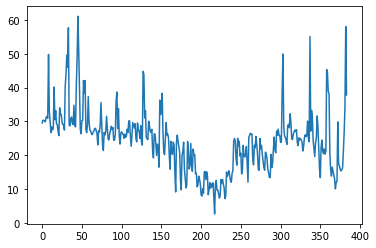

In [9]:
check_list = []
for i, batch in enumerate(ts_loader):
    insample_y = batch['insample_y']
    insample_x = batch['insample_x']
    insample_mask = batch['insample_mask']
    outsample_y = batch['outsample_y']
    outsample_x = batch['outsample_x']
    outsample_mask = batch['outsample_mask']

    #print("on_dataset.t_cols", on_dataset.t_cols)
    #print("ts_loader.input_size", ts_loader.input_size)
    #print("ts_loader.output_size", ts_loader.output_size)
    print("insample_y.shape", insample_y.shape)
    #print("insample_x.shape", insample_x.shape)
    #print("outsample_y.shape", outsample_y.shape)
    #print("outsample_x.shape", outsample_x.shape)

    check_list += [insample_y]

    if i>1: break

check = np.vstack(check_list)
print("check.shape", check.shape)
print("Checking order for unshuffled validation")
plt.plot(check[:,9])
plt.show()